<div style = "padding:30px;">
    <h2 style = "text-align:center;color:#4B0082 ;margin-bottom:25x;">  Mask Detection 😷 </h2>  
<div style = "text-align:center;">
    <img  src = "https://cssh.northeastern.edu/philosophy/wp-content/uploads/sites/11/2020/09/Illustrated-Community-Masks-3-with-Hijab.jpg" style ="width:90%;height:450px;"></div>
    </div>

<p style = "font-weight:bold;"> Hello, Welcome to my mask detection project 👋 </p>
<p>
The covid19 virus influence negatively our life since 2019 and the virus the first appearance place in the world was Wuhan city in China, 
and then spread all over world,from this moment we have to  wear a face maske in  crowded places such as cafe, restaurant.. While wearing mask is not the ultimate solution, it still reduces the rate of transmission of the virus.In addition much applications were produced by software developers. I devoloped this project to solve face mask problem.
</p>

in this notebook, following process is adopted:<br>
* Prepare mask and without mask images for classifiying model 
* Train the classifier to classify faces into mask or non-mask labels.
* Detect Face with Opencv Haar Cascade Classifier
* Classifiy Face with Pretrained VGG19 model

## import libraries

In [1]:
import pandas as pd # table operations
import numpy as np # linear algebra
import seaborn as sns # visualizing
import os # getting path
from sklearn.utils import shuffle
import matplotlib.pyplot as plt # visualizing
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # prepare image
import cv2 # haar cascade
from scipy.spatial import distance
import glob
from warnings import filterwarnings
from tensorflow.keras.applications import VGG19 # classify modle
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint # save best model weights
from tensorflow.keras.models import Model, load_model # load model
from sklearn.metrics import confusion_matrix
from skimage import io
filterwarnings("ignore")

The path is created for getting data and then I concatened dataframes of mask and without mask.

In [2]:
path  = "../input/face-mask-12k-images-dataset/Face Mask Dataset/"

In [3]:
dataset = {"image_path":[],"mask_status":[],"where":[]}
for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
dataset

,image_path,mask_status,where
0,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
1,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
2,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
3,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
4,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
...,...,...,...
11787,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
11788,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
11789,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
11790,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train


In [4]:
dataset.value_counts("mask_status")

mask_status
WithoutMask    5909
WithMask       5883
dtype: int64

With Mask: 5883,
Without Mask: 5909



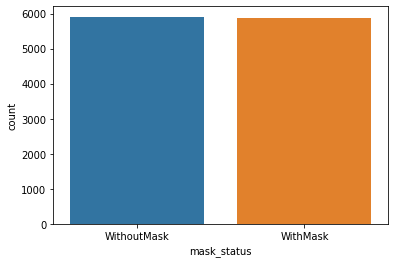

In [5]:
mask = dataset.value_counts("mask_status")[1]
withoutmask = dataset.value_counts("mask_status")[0]

print(f"With Mask: {mask},\nWithout Mask: {withoutmask}\n")
sns.countplot(dataset["mask_status"])
plt.show()

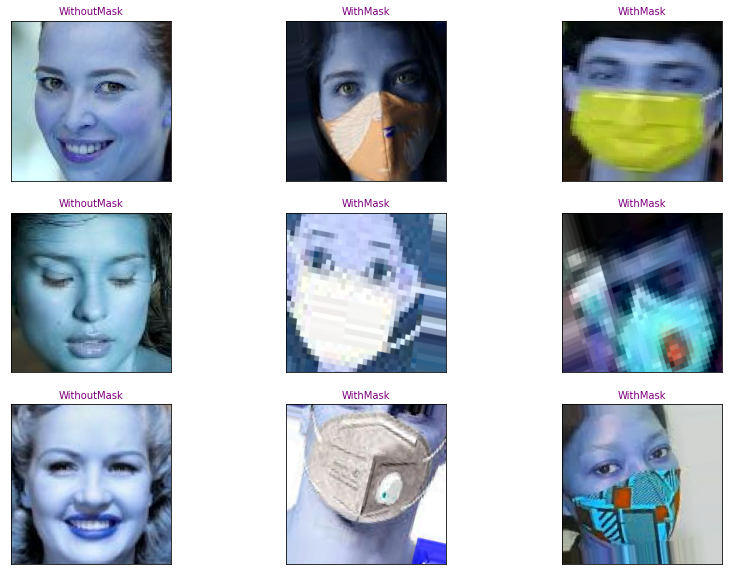

In [6]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(dataset))
    plt.subplot(3,3,i+1)
    plt.imshow(cv2.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random, "mask_status"], size = 10, color = "purple") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [7]:
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

In [8]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
valid_df = valid_df.sample(frac=1)


In [9]:
train_df.head()

,image_path,mask_status,where
5141,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Train
5264,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Train
9711,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
4721,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Train
3981,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Train


In [10]:
test_df.head()

,image_path,mask_status,where
1532,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Test
1720,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Test
1362,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Test
1108,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Test
1062,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Test


In [11]:
valid_df.head()

,image_path,mask_status,where
670,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Validation
689,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Validation
748,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Validation
372,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
687,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Validation


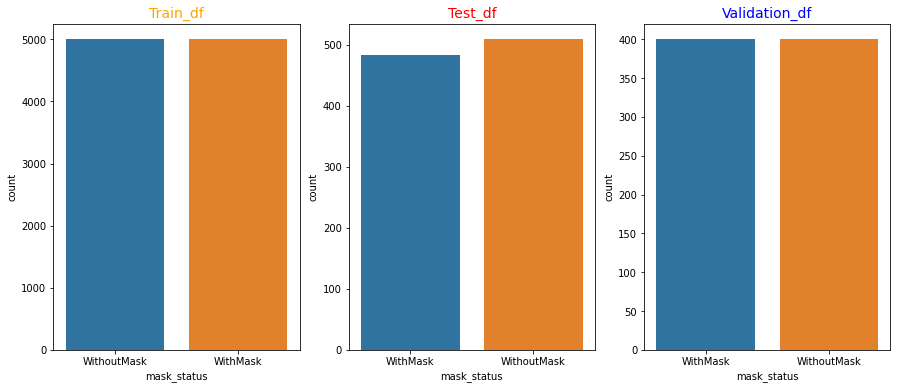

In [12]:
plt.figure(figsize = (15,6))
plt.subplot(1,3,1)
sns.countplot(train_df["mask_status"])
plt.title("Train_df", size = 14, color = "orange")


plt.subplot(1,3,2)
sns.countplot(test_df["mask_status"])
plt.title("Test_df", size = 14, color = "red")


plt.subplot(1,3,3)
sns.countplot(valid_df["mask_status"])
plt.title("Validation_df", size = 14, color = "blue")

plt.show()

## Preprocessing image 

In [13]:
datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="../input",
x_col="image_path",
y_col="mask_status",
batch_size=80,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(150,150))

Found 10000 validated image filenames belonging to 2 classes.


In [15]:
valid_generator=datagen.flow_from_dataframe(
dataframe=valid_df,
directory="../input",
x_col="image_path",
y_col="mask_status",
batch_size=80,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(150,150))

Found 800 validated image filenames belonging to 2 classes.


In [16]:
test_generator=datagen.flow_from_dataframe(
dataframe=test_df,
directory="../input",
x_col="image_path",
y_col="mask_status",
batch_size=80,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(150,150))

Found 992 validated image filenames belonging to 2 classes.


## Classify Model

In [17]:
model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in model.layers[2:]: 
  layer.trainable = False
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [18]:
x=Flatten()(model.output)
x2 = Dense(128, activation="relu")(x)
output=Dense(1,activation='sigmoid')(x2) # 
model=Model(model.input,output)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [20]:
# save best weights
checkpoint = ModelCheckpoint("classify_model.h5", save_best_only=True, verbose = 1)

In [21]:
model.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accuracy"])
history = model.fit_generator(train_generator,validation_data  = valid_generator, epochs = 10, steps_per_epoch=(len(train_generator.labels) / 80) ,validation_steps=(len(valid_generator.labels)/80), callbacks =[checkpoint])

Epoch 1/10
125/125 [==============================] - 77s 576ms/step - loss: 0.3502 - accuracy: 0.8744 - val_loss: 0.0124 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.01237, saving model to classify_model.h5
Epoch 2/10
125/125 [==============================] - 29s 233ms/step - loss: 0.0151 - accuracy: 0.9962 - val_loss: 0.0069 - val_accuracy: 0.9987

Epoch 00002: val_loss improved from 0.01237 to 0.00690, saving model to classify_model.h5
Epoch 3/10
125/125 [==============================] - 29s 233ms/step - loss: 0.0078 - accuracy: 0.9984 - val_loss: 0.0034 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.00690 to 0.00340, saving model to classify_model.h5
Epoch 4/10
125/125 [==============================] - 29s 234ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0020 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00340 to 0.00204, saving model to classify_model.h5
Epoch 5/10
125/125 [==============================] - 29s 23

In [22]:
# load model
model = load_model("classify_model.h5")

In [23]:
model.evaluate_generator(test_generator, verbose=1)

13/13 [==============================] - 8s 630ms/step - loss: 0.0174 - accuracy: 0.9990


[0.01740076392889023, 0.9989919066429138]

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Model evaluation

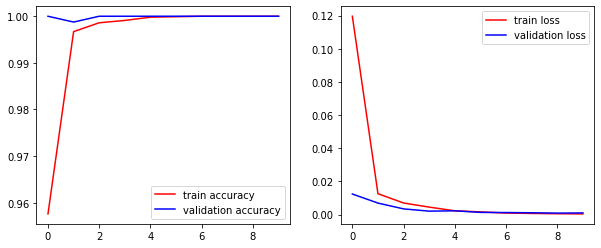

In [25]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label = "train accuracy", color = "red")
plt.plot(history.history["val_accuracy"], label = "validation accuracy", color = "blue")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "train loss", color = "red")
plt.plot(history.history["val_loss"], label = "validation loss", color = "blue")

plt.legend()
plt.show()

In [26]:
predictions = model.predict_generator(test_generator, verbose = 1,workers=-1)

13/13 [==============================] - 3s 252ms/step


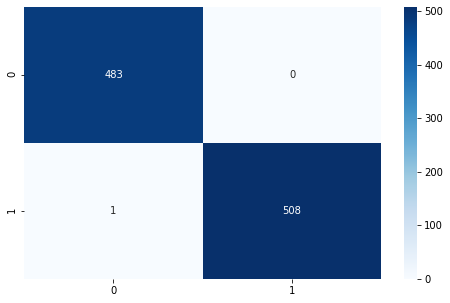

In [27]:
plt.figure(figsize = (8,5))
sns.heatmap(confusion_matrix(test_generator.labels, predictions.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

## Face detection Model

In [28]:
face_model = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_default.xml')

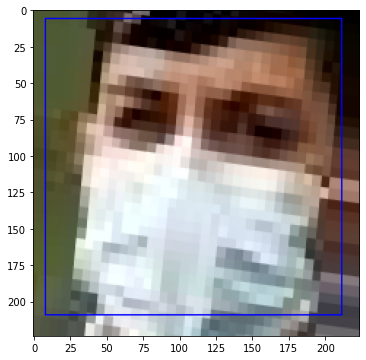

In [29]:
img = cv2.imread(train_df.loc[np.random.randint(1,len(train_df)),"image_path"])

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(6,6))
plt.imshow(out_img)
plt.show()

## The last check

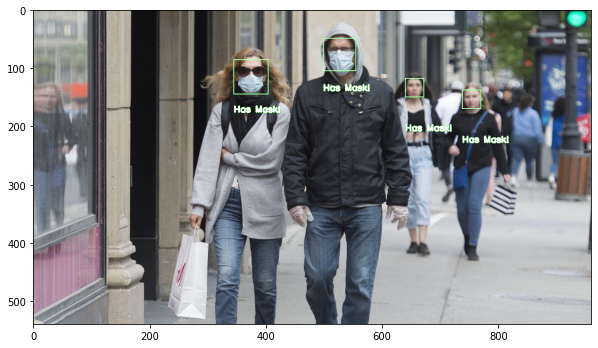

In [30]:
mask_label = {0:'Has Mask!',1:'No Mask'}
dist_label = {0:(0,255,0),1:(255,0,0)}
MIN_DISTANCE = 0

img= io.imread("https://www.ctvnews.ca/polopoly_fs/1.4986740.1592334933!/httpImage/image.jpg_gen/derivatives/landscape_960/image.jpg")

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=8)

if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(150,150))
        crop = np.reshape(crop,[1,150,150,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(img,mask_label[round(mask_result[0][0])],(x, y+90), cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(img)
            
else:
    print("No Face!")

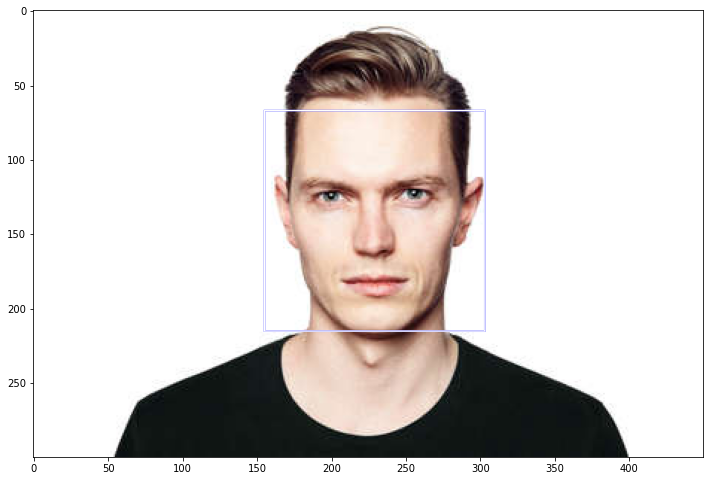

In [31]:
img = io.imread('https://us.123rf.com/450wm/filipw/filipw1602/filipw160200148/52231994-studio-shot-of-young-man-looking-at-the-camera-isolated-on-white-background-horizontal-format-he-has.jpg?ver=6')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)


for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(img)

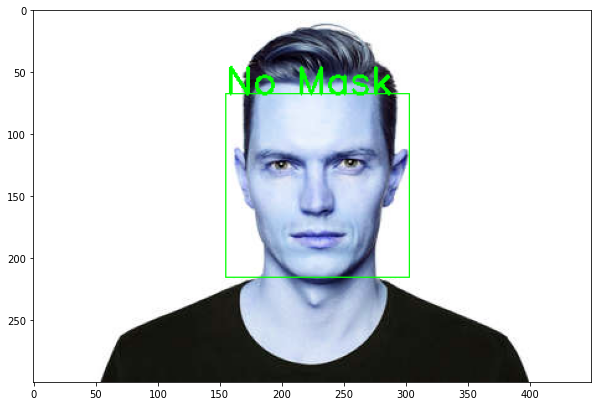

In [32]:
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(150,150))
        crop = np.reshape(crop,[1,150,150,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y), cv2.FONT_HERSHEY_SIMPLEX,1,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No Face!")

In [33]:
model.save("classify_model.h5")

<p style = "color:#8A2BE2;font-size:20px;">  👋 Please, if you have a suggestion, write feedback, Stay Healthy 😊 </p>